In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [3]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Why Target Stock Is Hopping and Walmart Is Slipping. Both Had Strong Earnings.
Aug-19-20 02:37PM  
Trump Likes The Idea Of Oracle Buying TikTok. Analysts Arent Convinced.
01:50PM  
Amazon to add thousands of jobs to Phoenix metro area
01:30PM  
Zoom Video to Soon Appear on Amazon, Facebook, and Google Smart Display Devices
01:14PM  


In [4]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news


[['AMZN',
  'Aug-19-20',
  '02:37PM',
  'Why Target Stock Is Hopping and Walmart Is Slipping. Both Had Strong Earnings.'],
 ['AMZN',
  'Aug-19-20',
  '01:50PM',
  'Trump Likes The Idea Of Oracle Buying TikTok. Analysts Arent Convinced.'],
 ['AMZN',
  'Aug-19-20',
  '01:30PM',
  'Amazon to add thousands of jobs to Phoenix metro area'],
 ['AMZN',
  'Aug-19-20',
  '01:14PM',
  'Zoom Video to Soon Appear on Amazon, Facebook, and Google Smart Display Devices'],
 ['AMZN',
  'Aug-19-20',
  '01:10PM',
  "1 Surprising Number From Walmart's Second Quarter Report"],
 ['AMZN',
  'Aug-19-20',
  '12:14PM',
  'Apple Breaks $2 Trillion Barrier in Latest Rally Milestone'],
 ['AMZN',
  'Aug-19-20',
  '12:10PM',
  'Amazon Wins\xa0Loyal Walmart Shoppers as Americans Stampede Online'],
 ['AMZN',
  'Aug-19-20',
  '12:04PM',
  'Amazon ramps up pressure on Walmart with fresh moves in online grocery'],
 ['AMZN', 'Aug-19-20', '11:58AM', 'Why Target Is Soaring Today'],
 ['AMZN',
  'Aug-19-20',
  '11:51AM',
  'Do

In [5]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.tail()

,ticker,date,time,headline,neg,neu,pos,compound
295,GOOG,2020-08-13,06:23PM,Crime-Tracking App Citizen Now Alerts Users to...,0.208,0.792,0.000,-0.2732
296,GOOG,2020-08-13,05:54PM,U.S. Justice Department going 'full tilt' on t...,0.000,0.746,0.254,0.5267
297,GOOG,2020-08-13,04:56PM,"Epic Games Brings a New Payment System to ""For...",0.000,1.000,0.000,0.0000
298,GOOG,2020-08-13,04:25PM,"Apple Inc. stock rises Thursday, outperforms m...",0.000,1.000,0.000,0.0000
299,GOOG,2020-08-13,04:25PM,"Amazon.com Inc. stock falls Thursday, still ou...",0.000,1.000,0.000,0.0000


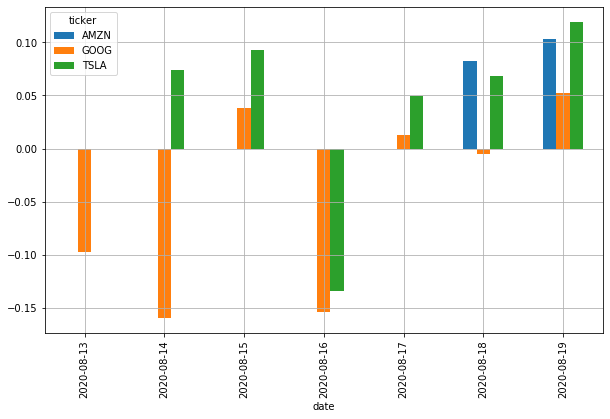

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [7]:
sentiment = parsed_and_scored_news
sentiment

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2020-08-19,02:37PM,Why Target Stock Is Hopping and Walmart Is Sli...,0.000,0.784,0.216,0.5106
1,AMZN,2020-08-19,01:50PM,Trump Likes The Idea Of Oracle Buying TikTok. ...,0.161,0.640,0.199,0.1386
2,AMZN,2020-08-19,01:30PM,Amazon to add thousands of jobs to Phoenix met...,0.000,0.841,0.159,0.1779
3,AMZN,2020-08-19,01:14PM,"Zoom Video to Soon Appear on Amazon, Facebook,...",0.000,0.714,0.286,0.5267
4,AMZN,2020-08-19,01:10PM,1 Surprising Number From Walmart's Second Quar...,0.000,0.595,0.405,0.3400
...,...,...,...,...,...,...,...,...
295,GOOG,2020-08-13,06:23PM,Crime-Tracking App Citizen Now Alerts Users to...,0.208,0.792,0.000,-0.2732
296,GOOG,2020-08-13,05:54PM,U.S. Justice Department going 'full tilt' on t...,0.000,0.746,0.254,0.5267
297,GOOG,2020-08-13,04:56PM,"Epic Games Brings a New Payment System to ""For...",0.000,1.000,0.000,0.0000
298,GOOG,2020-08-13,04:25PM,"Apple Inc. stock rises Thursday, outperforms m...",0.000,1.000,0.000,0.0000


In [8]:
sentiment["ticker"].value_counts()

TSLA    100
AMZN    100
GOOG    100
Name: ticker, dtype: int64

In [9]:
news_grouped = sentiment.groupby(['ticker','date'], as_index=False).sum()
news_grouped

,ticker,date,neg,neu,pos,compound
0,AMZN,2020-08-18,2.164,50.988,6.847,4.9680
1,AMZN,2020-08-19,3.444,29.880,6.675,4.1440
2,GOOG,2020-08-13,0.901,8.845,0.254,-0.9709
3,GOOG,2020-08-14,3.003,13.786,1.210,-2.8779
4,GOOG,2020-08-15,0.226,5.377,0.397,0.2295
5,GOOG,2020-08-16,0.989,4.661,0.349,-0.9254
6,GOOG,2020-08-17,1.997,20.800,2.203,0.3190
7,GOOG,2020-08-18,1.473,18.645,1.882,-0.1148
8,GOOG,2020-08-19,0.720,11.135,1.144,0.6806
9,TSLA,2020-08-14,0.676,13.023,1.301,1.1038


In [10]:
type(news_grouped)

pandas.core.frame.DataFrame

In [11]:
amzn = news_grouped.loc[news_grouped['ticker']=='AMZN']
amzn

,ticker,date,neg,neu,pos,compound
0,AMZN,2020-08-18,2.164,50.988,6.847,4.968
1,AMZN,2020-08-19,3.444,29.880,6.675,4.144


In [12]:
goog = news_grouped.loc[news_grouped['ticker']=='GOOG']
goog

,ticker,date,neg,neu,pos,compound
2,GOOG,2020-08-13,0.901,8.845,0.254,-0.9709
3,GOOG,2020-08-14,3.003,13.786,1.210,-2.8779
4,GOOG,2020-08-15,0.226,5.377,0.397,0.2295
5,GOOG,2020-08-16,0.989,4.661,0.349,-0.9254
6,GOOG,2020-08-17,1.997,20.800,2.203,0.3190
7,GOOG,2020-08-18,1.473,18.645,1.882,-0.1148
8,GOOG,2020-08-19,0.720,11.135,1.144,0.6806


In [13]:
tsla = news_grouped.loc[news_grouped['ticker']=='TSLA']
tsla

,ticker,date,neg,neu,pos,compound
9,TSLA,2020-08-14,0.676,13.023,1.301,1.1038
10,TSLA,2020-08-15,0.486,3.717,0.798,0.4654
11,TSLA,2020-08-16,0.213,2.787,0.000,-0.4019
12,TSLA,2020-08-17,1.356,30.957,2.687,1.7212
13,TSLA,2020-08-18,1.012,26.591,2.397,2.0571
14,TSLA,2020-08-19,0.000,11.225,0.775,1.4342


In [14]:
# Export file as a CSV, without the Pandas index, but with the header
amzn.to_csv("amzn.csv", index=False, header=True)
goog.to_csv("goog.csv", index=False, header=True)
tsla.to_csv("tsla.csv", index=False, header=True)